In [238]:
from data import get_orbit, random_config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import torch
import torch.nn as nn
from torchdiffeq import odeint
device = torch.device("mps")

In [242]:
import dotenv
from os import environ
env_file = '../.env'

f = open(env_file,'w')
f.write('PYTORCH_ENABLE_MPS_FALLBACK=1')
f.close()
dotenv.load_dotenv(env_file, override=True)
print("done")

ModuleNotFoundError: No module named 'dotenv'

In [110]:
num_steps = 500
state = random_config(nu=2e-1, min_radius=0.9, max_radius=1.8)
orbit, settings = get_orbit(state, t_points=num_steps, t_span=[0,15], nbodies=3)
state = state[:,1:]
orbit = orbit[:,1:]

In [239]:
class NeuralODE(nn.Module):
    def __init__(self):
        super().__init__()
        self.odefunc = mlp(
            input_dim = 6,
            hidden_dim = 32,
            output_dim = 6,
            hidden_depth = 4
        )

        def init(m):
            if isinstance(m, nn.Linear):
                std = 1.0 / np.sqrt(m.weight.size(1))
                m.weight.data.uniform_(-2.0 * std, 2.0 * std)
                m.bias.data.zero_()

        self.odefunc.apply(init)

    def forward(self, t, state):
        state_reshaped = torch.flatten(state[:,:2], start_dim = -2)
        acceleration = self.odefunc(state_reshaped).view(3, 2)
        acceleration = acceleration - acceleration.mean(dim = -2, keepdim = True)
        return torch.cat((state[:,2:], acceleration), dim = -1)

    def simulate(self, state, times):
        solution = odeint(self, state, times, atol=1e-8, rtol=1e-8, method="dopri5", options = {"dtype": torch.float32})
        # B, S, T
        return solution

def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None, act=nn.ReLU):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), act()]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), act()]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

In [240]:
state_tensor = torch.Tensor(state).to(device)
orbit_tensor = torch.Tensor(orbit).to(device)
print(state_tensor.dtype)
print(orbit_tensor.dtype)
model = NeuralODE().to(device)
model.train()
decay = 1.0
obs_times = torch.linspace(0, 15, num_steps).to(device)
print(obs_times.dtype)
lr = 0.1
num_iter = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.015)
weights = 1.0**obs_times


for itr in range(num_iter):
    optimizer.zero_grad()
    trajectory = torch.permute(model.simulate(state_tensor, obs_times), (1, 2, 0))
    loss = (
        (trajectory - orbit_tensor)
        .abs()
        .mul(weights)
        .mean()
    )
    if itr % 20 == 0:
        print(itr, loss.item())
    loss.backward()

    optimizer.step()

torch.float32
torch.float32
torch.float32


NotImplementedError: The operator 'aten::_unique2' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

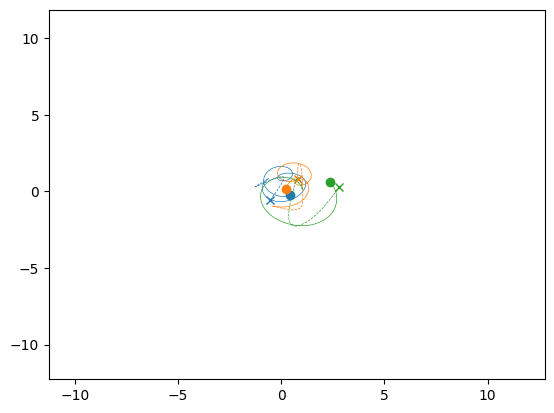

In [216]:
# B, S, T
positions = orbit.transpose(2,0,1)[:,:,:2]
predictions = trajectory.detach().numpy().transpose(2,0,1)[:,:,:2]
file_name = "fixed_orbit"
# Animation
# Animation setup
fig, ax = plt.subplots()
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)

# Original positions visualized with 'o' markers and solid lines for trajectories
lines = [ax.plot([], [], 'o')[0] for _ in range(3)]
# Store colors for reuse with approximated trajectories
colors = [f"C{_}" for _ in range(3)]
trajectories = [ax.plot([], [], '-', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

# Approximated positions visualized with 'x' markers and dotted lines for trajectories
# Use the same colors as the original trajectories
lines_approx = [ax.plot([], [], 'x', color=colors[_])[0] for _ in range(3)]
trajectories_approx = [ax.plot([], [], '--', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

def init():
    for line in lines + lines_approx:
        line.set_data([], [])
    for traj in trajectories + trajectories_approx:
        traj.set_data([], [])
    return lines + trajectories + lines_approx + trajectories_approx

def animate(i):
    if len(positions[:i,:,0]) != 0:
        all_x = np.concatenate((positions[:i, :, 0].flatten(), predictions[:i, :, 0].flatten()))
        all_y = np.concatenate((positions[:i, :, 1].flatten(), predictions[:i, :, 1].flatten()))
        min_x, max_x = all_x.min() - 10, all_x.max() + 10
        min_y, max_y = all_y.min() - 10, all_y.max() + 10
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

    for j, (line, line_approx) in enumerate(zip(lines, lines_approx)):
        # Update original positions and trajectories
        line.set_data(positions[i, j, 0], positions[i, j, 1])
        trajectories[j].set_data(positions[:i, j, 0], positions[:i, j, 1])
        
        # Update approximated positions and trajectories
        line_approx.set_data(predictions[i, j, 0], predictions[i, j, 1])
        trajectories_approx[j].set_data(predictions[:i, j, 0], predictions[:i, j, 1])

    return lines + trajectories + lines_approx + trajectories_approx

# Assuming num_steps is defined
ani = animation.FuncAnimation(fig, animate, frames=range(0, num_steps, 2), init_func=init, blit=True, interval=1)

# To save the animation
writergif = animation.PillowWriter(fps=50)
ani.save(f'{file_name}.gif', writer=writergif)

plt.show()

In [199]:
print(torch.sum(orbit_tensor[:,2:,-1] - orbit_tensor[:,2:,0], dim = 0))
print(torch.sum(trajectory[:,2:,-1] - trajectory[:,2:,0], dim = 0))
print(orbit_tensor[:,:,0])
print(trajectory[:,:,0])

tensor([-5.9605e-08,  5.9605e-08])
tensor([ 7.7486e-07, -2.3842e-07], grad_fn=<SumBackward1>)
tensor([[-0.6135,  0.8321, -0.5132, -0.4049],
        [-0.4139, -0.9473,  0.8112, -0.2727],
        [ 1.0273,  0.1152, -0.0932,  0.7149]])
tensor([[-0.6135,  0.8321, -0.5132, -0.4049],
        [-0.4139, -0.9473,  0.8112, -0.2727],
        [ 1.0273,  0.1152, -0.0932,  0.7149]], grad_fn=<SelectBackward0>)


In [49]:
print(positions.shape)
print(orbit.shape)
print(state.shape)
print(state[:,0])

(500, 3, 2)
(3, 4, 500)
(3, 4)
[ 1.70619011 -1.33122881 -0.3749613 ]
